In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.decomposition import FactorAnalysis

In [2]:
# Read in processed data.
df = pd.read_csv('summary_fall2020 (30 sec ML no conf in OAT scores).csv')

# Somehow, there are two people with raw scores (sums) greater than 75.  This should not be possible.
# I have double checked the Testable version, and it indeed does have the correct questions.

# Compute additional measure (resistance to disattending threat).
df = df.assign(resistance = df.threat_benign_os - df.threat_benign_brel)

# Compute transformed values of relevant variables.
df = df.assign(sqrt_eta0 = np.sqrt(df.eta0))
df = df.assign(log_eta0 = np.log(df.eta0))

df_good = df.loc[df.good_perf] # only participants who pass the performance criterion
df_inlab = df_good.loc[df_good.source == 'inlab']
df_online = df_good.loc[df_good.source == 'online']

df_norm = pd.DataFrame(0.0,
                       index = df.index,
                       columns = ['eta0', 'sqrt_eta0', 'log_eta0', 'threat_benign_os', 'promis_anx', 'promis_ang', 'promis_dep',  'promis_pos', 'bite', 'avg_last8_pct_correct'])
for var_name in df_norm.columns.values:
    df_norm[var_name] = (df[var_name] - df[var_name].mean())/df[var_name].std()
df_norm['good_perf'] = df['good_perf']
df_good_norm = df_norm.loc[df_norm.good_perf]
#print(df.head())
print(df.columns)
print(df.shape[0])
print(df_good.shape[0])

Index(['ident', 'schedule', 'age', 'sex', 'latinx', 'race', 'employment',
       'tutorial_0a_last8_pct_correct', 'tutorial_0b_last8_pct_correct',
       'tutorial_0c_last8_pct_correct', 'training_last8_pct_correct',
       'transfer_last8_pct_correct', 'rel_irl', 'threat_benign_os',
       'threat_benign_brel', 'threat_benign_trel', 'promis_anx_resp1',
       'promis_anx_resp2', 'promis_anx_resp3', 'promis_anx_resp4',
       'promis_anx_resp5', 'promis_anx_resp6', 'promis_anx_resp7',
       'promis_anx_resp8', 'promis_anx_sum', 'promis_anx_std', 'promis_anx',
       'promis_ang_resp1', 'promis_ang_resp2', 'promis_ang_resp3',
       'promis_ang_resp4', 'promis_ang_resp5', 'promis_ang_sum',
       'promis_ang_std', 'promis_ang', 'promis_dep_resp1', 'promis_dep_resp2',
       'promis_dep_resp3', 'promis_dep_resp4', 'promis_dep_resp5',
       'promis_dep_resp6', 'promis_dep_resp7', 'promis_dep_resp8',
       'promis_dep_sum', 'promis_dep_std', 'promis_dep', 'promis_pos_resp1',
       'pro

plots


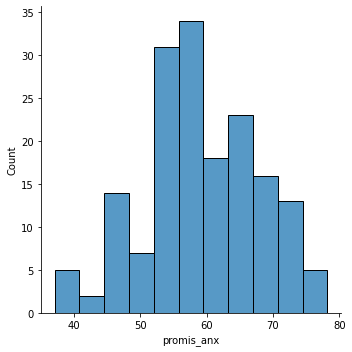

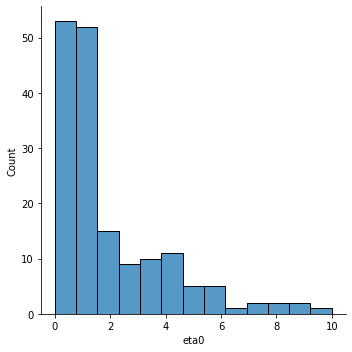

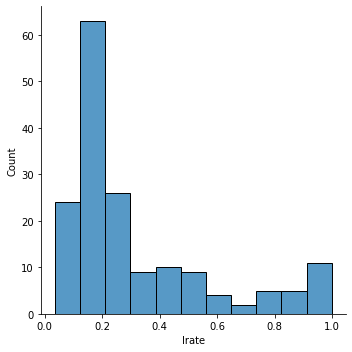

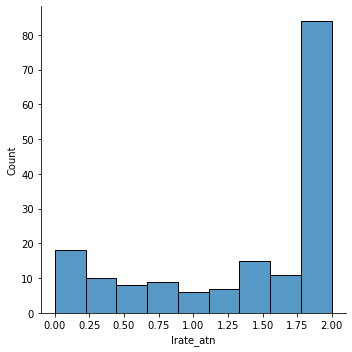

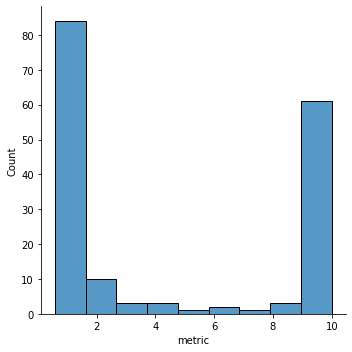

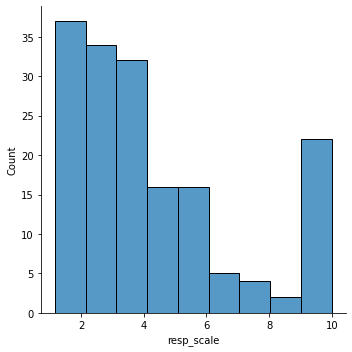

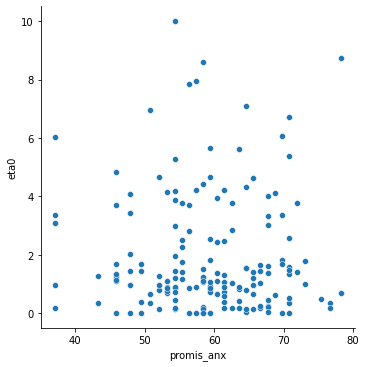

In [9]:
print('plots')
data = df_good
sns.displot(data['promis_anx'])
sns.displot(data['eta0'])
sns.displot(data['lrate'])
sns.displot(data['lrate_atn'])
sns.displot(data['metric'])
sns.displot(data['resp_scale'])
sns.relplot(x = 'promis_anx', y = 'eta0', data = data)

In [4]:
print('Looking for differences between online and inlab participants:')
ttests = pd.DataFrame(0.0,
                      index = ['training_last8_pct_correct', 'transfer_last8_pct_correct', 'rel_irl', 'threat_benign_os', 'threat_benign_ri', 'eta0'],
                      columns = ['t', 'p', 'mean_inlab', 'mean_online'])
for var_name in ttests.index.values:
    result = stats.ttest_ind(df.loc[df.source == 'online'][var_name], df.loc[df.source == 'inlab'][var_name])
    ttests.loc[var_name]['t'] = np.round(result.statistic, 3)
    ttests.loc[var_name]['p'] = np.round(result.pvalue, 3)
    ttests.loc[var_name]['mean_online'] = np.round(df.loc[df.source == 'online'][var_name].mean(), 3)
    ttests.loc[var_name]['mean_inlab'] = np.round(df.loc[df.source == 'inlab'][var_name].mean(), 3)
print(ttests)
print('It appears that participants in the lab performed better and had a larger rel_irl effect.')

Looking for differences between online and inlab participants:
                                t      p  mean_inlab  mean_online
training_last8_pct_correct -2.942  0.004      81.004       72.991
transfer_last8_pct_correct -3.151  0.002      86.516       78.646
rel_irl                    -3.119  0.002       0.398        0.207
threat_benign_os            0.034  0.973       0.087        0.089
threat_benign_ri           -1.275  0.203       0.020       -0.043
eta0                       -0.212  0.832       2.549        2.476
It appears that participants in the lab performed better and had a larger rel_irl effect.


In [11]:
data = df_good

ttests = pd.DataFrame(0.0,
                      index = ['threat_benign_os', 'resistance', 'rel_irl', 'eta0'],
                      columns = ['t', 'p', 'effect_size', 'mean', 'std'])
n = data.shape[0]
for var_name in ttests.index.values:
    if var_name == 'eta0':
        popmean = 1
    else:
        popmean = 0
    result = stats.ttest_1samp(data[var_name], popmean)
    ttests.loc[var_name]['t'] = np.round(result.statistic, 3)
    ttests.loc[var_name]['p'] = np.round(result.pvalue, 3)
    ttests.loc[var_name]['effect_size'] = np.round(result.statistic/np.sqrt(n), 3)
    ttests.loc[var_name]['mean'] = np.round(data[var_name].mean(), 3)
    ttests.loc[var_name]['std'] = np.round(data[var_name].std(), 3)

print('t tests for OAT scores and salience parameter (eta0):')
print('n = ' + str(n))
print(ttests)

t tests for OAT scores and salience parameter (eta0):
n = 168
                       t      p  effect_size   mean    std
threat_benign_os   1.621  0.107        0.125  0.086  0.690
resistance         8.324  0.000        0.642  0.610  0.950
rel_irl           13.063  0.000        1.008  0.515  0.511
eta0               5.876  0.000        0.453  1.919  2.026


In [5]:
data = df_good

rtests = pd.DataFrame(0.0,
                      index = ['threat_benign_os', 'resistance', 'rel_irl', 'eta0'],
                      columns = ['r', 'p'])
n = data.shape[0]
for var_name in rtests.index.values:
    (r, p) = stats.pearsonr(data['promis_anx'], data[var_name])
    rtests.loc[var_name]['r'] = np.round(r, 2)
    rtests.loc[var_name]['p'] = np.round(p, 4)
print('CORRELATIONS WITH PROMIS ANXIETY \n')
print('n = ' + str(n))
print(rtests)

CORRELATIONS WITH PROMIS ANXIETY 

n = 80
                     r       p
threat_benign_os -0.15  0.1795
resistance       -0.11  0.3315
rel_irl          -0.03  0.7645
eta0             -0.03  0.8194


In [14]:
print('proportion of participants who met performance criterion:')
# The spring data only include people without any missing data (several were missing OAT scores).
perf_summary = pd.DataFrame(index = ['spring', 'fall_total', 'fall_inlab', 'fall_online'],
                            columns = ['total', 'good', 'pct_good'])
perf_summary.loc['spring']['total'] = 153
perf_summary.loc['spring']['good'] = 106
perf_summary.loc['spring']['pct_good'] = 100*106/153
perf_summary.loc['fall_total']['total'] = df.shape[0]
perf_summary.loc['fall_total']['good'] = df['good_perf'].sum()
perf_summary.loc['fall_total']['pct_good'] = 100*df['good_perf'].sum()/df.shape[0]
perf_summary.loc['fall_inlab']['total'] = df.loc[df.source == 'inlab'].shape[0]
perf_summary.loc['fall_inlab']['good'] = df.loc[df.source == 'inlab']['good_perf'].sum()
perf_summary.loc['fall_inlab']['pct_good'] = 100*df.loc[df.source == 'inlab']['good_perf'].sum()/df.loc[df.source == 'inlab'].shape[0]
perf_summary.loc['fall_online']['total'] = df.loc[df.source == 'online'].shape[0]
perf_summary.loc['fall_online']['good'] = df.loc[df.source == 'online']['good_perf'].sum()
perf_summary.loc['fall_online']['pct_good'] = 100*df.loc[df.source == 'online']['good_perf'].sum()/df.loc[df.source == 'online'].shape[0]
print(perf_summary)

proportion of participants who met performance criterion:
            total good pct_good
spring        153  106   69.281
fall_total    295  168  56.9492
fall_inlab    127   88  69.2913
fall_online   168   80   47.619


In [6]:
print('CORRELATIONS \n')
data = df_good
x = ['eta0'] + 3*['promis_anx'] + 2*['promis_ang'] + 3*['promis_anx'] + ['promis_ang']
y = ['threat_benign_os', 'threat_benign_ri'] + 2*['threat_benign_os', 'eta0'] + ['promis_ang', 'promis_pos', 'bite', 'bite']
n_rows = len(x)
rtests = pd.DataFrame(index = range(n_rows),
                      columns = ['x', 'y', 'r', 'p'])
for i in range(n_rows):
    rtests.iloc[i]['x'] = x[i]
    rtests.iloc[i]['y'] = y[i]
    (r, p) = stats.pearsonr(data[x[i]], data[y[i]])
    rtests.iloc[i]['r'] = np.round(r, 2)
    rtests.iloc[i]['p'] = np.round(p, 4)
print(rtests)

CORRELATIONS 

            x                 y     r       p
0        eta0  threat_benign_os  0.24  0.0015
1  promis_anx  threat_benign_ri -0.03  0.7363
2  promis_anx  threat_benign_os -0.15  0.0467
3  promis_anx              eta0  0.01  0.9049
4  promis_ang  threat_benign_os -0.13  0.0874
5  promis_ang              eta0  0.05  0.5306
6  promis_anx        promis_ang  0.65       0
7  promis_anx        promis_pos -0.56       0
8  promis_anx              bite  0.62       0
9  promis_ang              bite  0.81       0


In [15]:
print('correlations between parameters \n')
data = df_good
print(np.round(data[['eta0', 'lrate', 'lrate_atn', 'metric', 'resp_scale']].corr(), 2))

correlations between parameters 

            eta0  lrate  lrate_atn  metric  resp_scale
eta0        1.00  -0.13       0.29    0.35       -0.23
lrate      -0.13   1.00      -0.12   -0.18       -0.31
lrate_atn   0.29  -0.12       1.00    0.06       -0.12
metric      0.35  -0.18       0.06    1.00       -0.47
resp_scale -0.23  -0.31      -0.12   -0.47        1.00


In [26]:
# When eta0 for benign is left free and eta0 for threat is left fixed at 1,
# we get significant effects in the expected direction.
var = 'threat_benign_os'
#var = 'eta0'
model = smf.ols(formula = var + ' ~ promis_anx*avg_last8_pct_correct',
                data = df_norm)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       threat_benign_os   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.722
Date:                Wed, 20 Jan 2021   Prob (F-statistic):              0.163
Time:                        10:48:27   Log-Likelihood:                -415.49
No. Observations:                 295   AIC:                             839.0
Df Residuals:                     291   BIC:                             853.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

[1.393 0.23  5.   ]
                            OLS Regression Results                            
Dep. Variable:       threat_benign_os   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.393
Date:                Wed, 20 Jan 2021   Prob (F-statistic):              0.230
Time:                        10:49:38   Log-Likelihood:                -240.73
No. Observations:                 168   AIC:                             493.5
Df Residuals:                     162   BIC:                             512.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0079      0.080

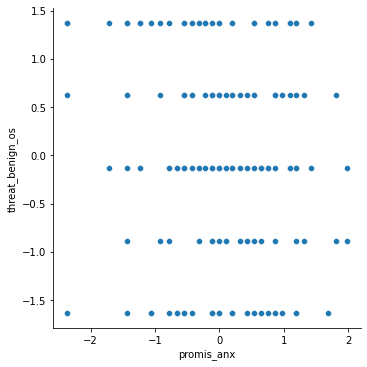

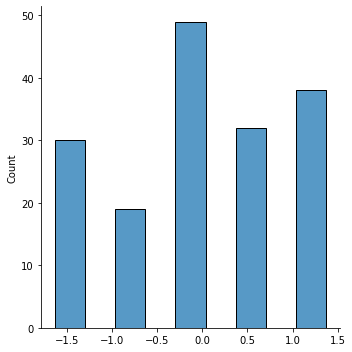

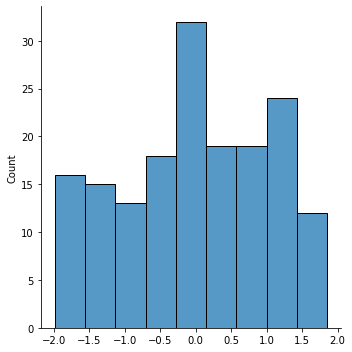

In [28]:
# REGRESSION MODELS
data = df_good_norm
#y = 'eta0'
y = 'threat_benign_os'
model0 = smf.ols(formula = y + ' ~ 1',
                 data = data)
model1 = smf.ols(formula = y + ' ~ promis_anx + promis_ang + promis_dep + promis_pos + bite',
                 data = data)
result0 = model0.fit()
result1 = model1.fit()
# I should determine if the whole model (considering all of the psych measures together) is predictive.
print(np.round(result1.compare_f_test(result0), 3))
print(result1.summary())

# Do a variance inflation test (predictors are highly correlated, so this might not work properly).
# Do robust regression.
# Also do factor analysis.

#https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
#https://www.statsmodels.org/stable/examples/notebooks/generated/regression_diagnostics.html
infl = result1.get_influence()
print(2/np.sqrt(data.shape[0]))
print(np.abs(infl.summary_frame().filter(regex="dfb")).max())

sns.relplot(x = 'promis_anx', y = y, data = data)
sns.displot(result0.resid)
sns.displot(result1.resid)

In [ ]:
# UPDATE EVERYTHING BELOW

In [ ]:
print('Demographic Breakdown (In Lab) \n')

print(summary_fall2020_inlab['sex'].value_counts())
print('\n')
print(summary_fall2020_inlab['latinx'].value_counts())
print('\n')
print(summary_fall2020_inlab['race'].value_counts())

In [ ]:
print('Demographic Breakdown (Online) \n')

print(summary_fall2020_online['sex'].value_counts())
print('\n')
print(summary_fall2020_online['latinx'].value_counts())
print('\n')
print(summary_fall2020_online['race'].value_counts())

In [ ]:
print('Raw Behavioral Scores (In Lab) \n')

score_name = ['rel_irl', 'threat_benign_os', 'threat_benign_ri']
n_score = len(score_name)
mean = np.zeros(n_score)
t_val = np.zeros(n_score)
p_val = np.zeros(n_score)
for i in range(n_score):
    mean[i] = np.round(summary_fall2020_inlab[score_name[i]].mean(), 2)
    t_test = np.round(stats.ttest_1samp(summary_fall2020_inlab[score_name[i]], popmean = 0), 4)
    t_val[i] = t_test[0]
    p_val[i] = t_test[1]
behav_scores_tests = pd.DataFrame({'score_name': score_name, 'mean': mean, 't_val': t_val, 'p_val': p_val})
print(behav_scores_tests)

In [ ]:
print('Raw Behavioral Scores (Online) \n')

score_name = ['rel_irl', 'threat_benign_os', 'threat_benign_ri']
n_score = len(score_name)
mean = np.zeros(n_score)
t_val = np.zeros(n_score)
p_val = np.zeros(n_score)
for i in range(n_score):
    mean[i] = np.round(summary_fall2020_online[score_name[i]].mean(), 2)
    t_test = np.round(stats.ttest_1samp(summary_fall2020_online[score_name[i]], popmean = 0), 4)
    t_val[i] = t_test[0]
    p_val[i] = t_test[1]
behav_scores_tests = pd.DataFrame({'score_name': score_name, 'mean': mean, 't_val': t_val, 'p_val': p_val})
print(behav_scores_tests)

In [ ]:
print('Percent Correct per Stage (In Lab) \n')

stage_name = ['tutorial_0a', 'tutorial_0b', 'tutorial_0c', 'training', 'transfer']
n_stage = len(stage_name)
mean = np.zeros(n_stage)
t_val = np.zeros(n_stage)
p_val = np.zeros(n_stage)
for i in range(n_stage):
    mean[i] = np.round(summary_fall2020_inlab[stage_name[i] + '_pct_correct'].mean(), 2)
    t_test = np.round(stats.ttest_1samp(summary_fall2020_inlab[stage_name[i] + '_pct_correct'], popmean = 50), 4)
    t_val[i] = t_test[0]
    p_val[i] = t_test[1]
pct_correct_tests = pd.DataFrame({'stage_name': stage_name, 'mean': mean, 't_val': t_val, 'p_val': p_val})
print(pct_correct_tests)

In [ ]:
print('Percent Correct per Stage (Online) \n')

stage_name = ['tutorial_0a', 'tutorial_0b', 'tutorial_0c', 'training', 'transfer']
n_stage = len(stage_name)
mean = np.zeros(n_stage)
t_val = np.zeros(n_stage)
p_val = np.zeros(n_stage)
for i in range(n_stage):
    mean[i] = np.round(summary_fall2020_online[stage_name[i] + '_pct_correct'].mean(), 2)
    t_test = np.round(stats.ttest_1samp(summary_fall2020_online[stage_name[i] + '_pct_correct'], popmean = 50), 4)
    t_val[i] = t_test[0]
    p_val[i] = t_test[1]
pct_correct_tests = pd.DataFrame({'stage_name': stage_name, 'mean': mean, 't_val': t_val, 'p_val': p_val})
print(pct_correct_tests)

In [ ]:
sns.displot(summary_fall2020_online[stage_name[0] + '_pct_correct'])

In [ ]:
print(np.round(stats.ttest_1samp(df['eta0'], popmean = 1), 4))
print(np.round(stats.ttest_1samp(df['threat_benign_os'], popmean = 0), 4))
d = df['threat_benign_os'].mean()/df['threat_benign_os'].std()
print(d)